In [1]:
%matplotlib inline
from qutip import*
from pylab import*
from numpy import*
import scipy.constants as sc
import random
import lmfit
from scipy.signal import find_peaks_cwt
from lmfit import  Model
from scipy.fftpack import fft, ifft
import peakutils

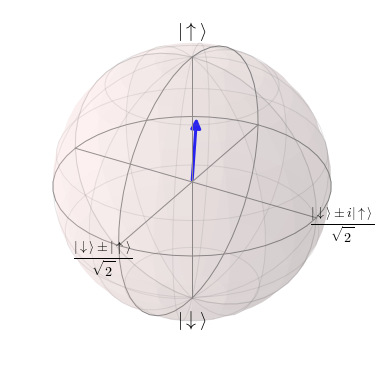

In [38]:
b = Bloch()
vec = [2.2,1.3,1.9]
b.add_vectors(vec)
b.show()
#savefig('BS1.svg')
#b.save('TEST', format='png', dirc=None)

/home/sebastian2/anaconda3/lib/python3.5/site-packages/qutip/bloch.py:590: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ceil(num / float(len(self.point_color))))


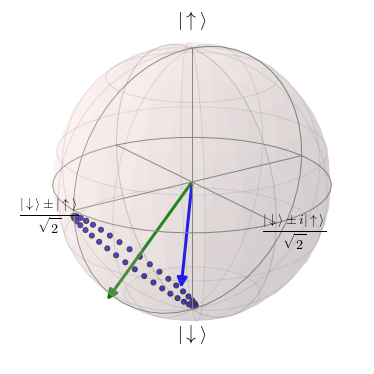

In [88]:
b = Bloch()
#b.clear()
vec = [0.1,0,-0.82]
vecc = [0.75,0,-0.75]
xz = [0.4*np.cos(th)+0.5 for th in np.linspace(0, 2*pi, 40)]
yz = [0.5*np.sin(th) for th in np.linspace(0, 2*pi, 40)]
zz = [0.4*np.cos(th)-0.5 for th in np.linspace(0, 2*pi, 40)]
b.clear()
b.add_vectors(vec)
b.add_points([xz, yz, zz],'m')
b.add_vectors(vecc)
b.view = [-35,20]
b.show()

/home/sebastian2/anaconda3/lib/python3.5/site-packages/qutip/bloch.py:590: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ceil(num / float(len(self.point_color))))


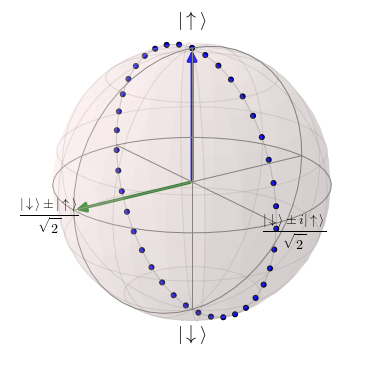

In [95]:
b = Bloch()
#b.clear()
vec = [0,0,1]
vecc = [1,0,0]
xz = np.zeros(40)
yz = [np.sin(th) for th in np.linspace(0, 2*pi, 40)]
zz = [np.cos(th) for th in np.linspace(0, 2*pi, 40)]
b.clear()
b.add_vectors(vec)
b.add_points([xz, yz, zz],'m')
b.add_vectors(vecc)
b.view = [-35,20]
b.show()

In [32]:
def qubit_integrate(w, theta, gamma1, gamma2, psi0, tlist):
    # operators and the hamiltonian
    sx = sigmax(); sy = sigmay(); sz = sigmaz(); sm = sigmam()
    H = w * (cos(theta) * sz + sin(theta) * sx)
    # collapse operators
    c_op_list = []
    n_th = 0.5 # temperature
    rate = gamma1 * (n_th + 1)
    if rate > 0.0: c_op_list.append(sqrt(rate) * sm)
    rate = gamma1 * n_th
    if rate > 0.0: c_op_list.append(sqrt(rate) * sm.dag())
    rate = gamma2
    if rate > 0.0: c_op_list.append(sqrt(rate) * sz)


    # evolve and calculate expectation values
    output = mesolve(H, psi0, tlist, c_op_list, [sx, sy, sz])  
    return output.expect[0], output.expect[1], output.expect[2]
    
## calculate the dynamics
w     = 1.0 * 2 * pi   # qubit angular frequency
theta = 0.2 * pi       # qubit angle from sigma_z axis (toward sigma_x axis)
gamma1 = 0.5      # qubit relaxation rate
gamma2 = 0.2      # qubit dephasing rate
# initial state
a = 1.0
psi0 = (a* basis(2,0) + (1-a)*basis(2,1))/(sqrt(a**2 + (1-a)**2))
tlist =  linspace(0,1,2)
#expectation values for ploting
sx, sy, sz = qubit_integrate(w, theta, gamma1, gamma2, psi0, tlist)






In [96]:
b = Bloch()

vece = [0,1,0.8]
b.clear()
b.add_vectors(vec)
b.add_vectors(vecc)
b.add_points([xz, yz, zz])
b.view = [-35,20]
b.save(format='svg',dirc='temp') #saving images to temp directory in current working directory

In [3]:
#Define a two level hamiltonian for rabi oscillation and introduce a third state to which the population of the nS and nP
#can decay to. This consverse the population of the system.

def la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX):
    hbar = 1
    
    # defining the basis
    S = basis(3,0) #Rydberg nS state
    P = basis(3,1) #Rydberg nP state
    X = basis(3,2) #Reservoir state
    
    # defining the operators
    sSS = tensor(S*S.dag())
    sPP = tensor(P*P.dag())
    sXX = tensor(X*X.dag())
    sPS = tensor(P*S.dag())
    sXS = tensor(X*S.dag())
    sSP = sPS.dag()
    sPX = tensor(P*X.dag())
    sSX = tensor(S*X.dag())
    sXP = sPX.dag()
    
    sz = Qobj([[1,0,0], [0,-1,0],[0,0,0]])
    
    # defining the hamiltonian
    H0 = - hbar * dP * sPP
    HI = - hbar * omegaP * (sPS + sSP)/2
    H = H0 + HI
    
    # defining the collapse operators
    c1=sqrt(gamma_SX)*sXS
    c2=sqrt(gamma_PX)*sXP
    collapse=[c1,c2]
    
    # projection operators to pure states
    projops = [sSS, sPP, sXX, sz]
    
    return H, collapse, projops

def la3level_RWA(tlist,psi0,omegaP,dP,gamma_SSs,gamma_es):
    H, collapse, projops = la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX)
    return mesolve(H, psi0, tlist, collapse, projops)

def la3level_RWA_steady(psi0,omegaP,omegaC,dP,dC,gamma_SX,gamma_PX):
    H, collapse, projops = la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX)
    return steadystate(H,collapse)

def rabi3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX):
    hbar = 1
    
    # defining the basis
    S = basis(3,0) #Rydberg nS state
    P = basis(3,1) #Rydberg nP state
    X = basis(3,2) #Reservoir state
    
    # defining the operators
    sSS = tensor(S*S.dag())
    sPP = tensor(P*P.dag())
    sXX = tensor(X*X.dag())
    sPS = tensor(P*S.dag())
    sXS = tensor(X*S.dag())
    sSP = sPS.dag()
    sPX = tensor(P*X.dag())
    sSX = tensor(S*X.dag())
    sXP = sPX.dag()
    
    sz = Qobj([[1,0,0], [0,-1,0],[0,0,0]])
    
    # defining the hamiltonian
    H0 = - hbar * dP * sPP
    HI = - hbar * omegaP * (sPS + sSP)/2
    H = H0 + HI
    
    # defining the collapse operators
    c1=sqrt(gamma_SX)*sXS
    c2=sqrt(gamma_PX)*sXP
    collapse=[c1,c2]
    
    # evolving Lindblad equation in time
    return mesolve(H, psi0, tlist, collapse, [sPP, sSS, sXX])

#Include field fluctuations
def la3level_RWA_EfieldFluctuations(tlist,psi0,omegaP,dP,gamma_PX,gamma_SX,sig_det,Nruns):
    dP_list = [random.gauss(dP,sig_det) for _ in range(Nruns)]
    expected_0 = tlist*0
    expected_1 = tlist*0
    expected_2 = tlist*0
    expected_3 = tlist*0
    for dP in dP_list:
        H,collapse, projops = la3level_Hamiltonian(omegaP,dP,gamma_PX,gamma_SX)
        result = mesolve(H, psi0, tlist, collapse, projops)
        expected_0 += result.expect[0]
        expected_1 += result.expect[1]
        expected_2 += result.expect[2]
        expected_3 += result.expect[3]
    return result.times, expected_0/Nruns, expected_1/Nruns, expected_2/Nruns, expected_3/Nruns


/home/sebastian2/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


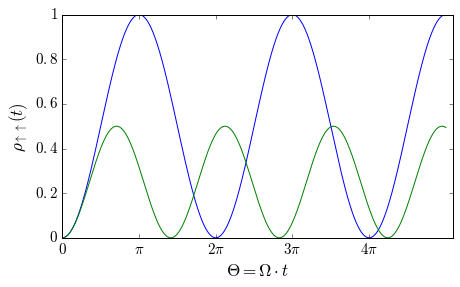

In [109]:
#Change the rabi frequency, detuning and decay rates.
plt.figure(figsize=(7,4))
psi0 = basis(3,0) #nS-State
omegaP = 1; dP = omegaP*0; 
tlist = linspace(0, 5*pi, 2000)

#omegaP = 2*pi; dP = omegaP*0; 
gamma_SX = 1/35.3*0; 
gamma_PX = 1/53.5*0; 

results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
#title('Rabi osc')
ylabel(r'$\rho_{\uparrow \uparrow}(t)$ ', fontsize=17)
xlabel("$\Theta = \Omega \cdot t$", fontsize=17)
p2 = plot(results.times, results.expect[1],'b',alpha = 1)
legend(loc='upper right')


dP = omegaP;
results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
p3 = plot(results.times, results.expect[1],'g-',alpha = 1)
#p4 = plot(results.times, results.expect[2],'darkorange',alpha = 1,label=r'$\rho_{RR} (t)$ ')
legend(loc='upper right')
#show()



plt.xticks([0, pi, 2*pi , 3*pi, 4*pi],
         
    ['$0$', r'$\pi$', r'$2 \pi$', r'$3 \pi$', r'$4 \pi$'], fontsize=15)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)

#, 2*pi, 3*pi, 4*pi, 5*pi, 6*pi
#, r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$'
savefig('Rabi_phase.svg')


In [75]:
results.expect[1]

array([ 0.        ,  0.0022188 ,  0.00883271, ...,  0.21634917,
        0.22639893,  0.2346272 ])

/home/sebastian2/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[Model]]
    Model(decay)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 42
    # variables        = 1
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -652.142
    Bayesian info crit = -650.405
[[Variables]]
    tau:   42.6002615 +/- 0.011208 (0.03%) (init= 40)
[[Correlations]] (unreported correlations are <  0.100)



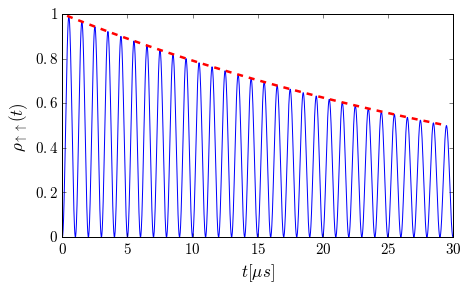

In [77]:
#Change the rabi frequency, detuning and decay rates.
plt.figure(figsize=(7,4))
psi0 = basis(3,0) #nS-State
tlist = linspace(0, 30, 2000)

omegaP = 2*pi; dP = omegaP*0; 
gamma_SX = 1/35.3*1; 
gamma_PX = 1/53.5*1; 

results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
#title('Rabi osc')
ylabel(r'$\rho_{\uparrow \uparrow}(t)$ ', fontsize=17)
xlabel("$t[\mu s]$", fontsize=17)
p2 = plot(results.times, results.expect[1],'b',alpha = 1)
#p11 = plot(results.times, results.expect[0],'g',alpha = 1,label=r'$\Delta = 0$')
legend(loc='upper right')


dP = omegaP;
results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
#p3 = plot(results.times, results.expect[1],'g-',alpha = 1,label=r'$\Delta = \Omega$ ')
#p4 = plot(results.times, results.expect[2],'darkorange',alpha = 1,label=r'$\rho_{RR} (t)$ ')
legend(loc='upper right')
#show()



plt.xticks([0, 5, 10, 15, 20, 25, 30],
           ['$0$', r'$5$', r'$10$', r'$15$', r'$20$', r'$25$', r'$30$'], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)
ylim(0,1)
#, 2*pi, 3*pi, 4*pi, 5*pi, 6*pi
#, r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$'



#Find peaks
indexes = peakutils.indexes(results.expect[1], min_dist=0.0001)
#plot(results.times[indexes],2*results.expect[1][indexes],'rp')
    
#FFTfuncp = FFTfunc[indexes] # Peaks of the FFT
#FFTwp = FFTw[indexes] # Corresponding x values


t = results.times[indexes]
y = 2*results.expect[1][indexes] #nS state

def decay(t, tau):
    return 1*np.exp(-t/tau)

gmod = Model(decay)
result = gmod.fit(y, t=t, tau=1/0.025)
print(result.fit_report())
p6 = plot(t, result.best_fit, 'r--', linewidth=2.5)

savefig('2_p_upup_decay42.pdf')

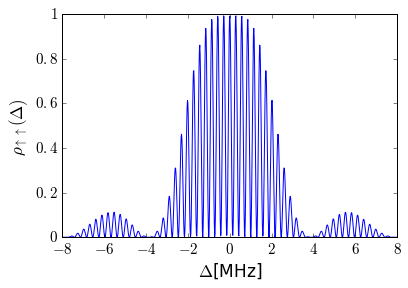

In [26]:
O= 2*pi*0+1*1
D = linspace(-8,8,900)

OE = sqrt(D**2+O**2)
T = 20
t = 1/4*0+pi/2 *1


pee = 4*(O**2/OE**2)*sin(OE*t/2)**2 *(cos(D*T/2)*cos(OE*t/2) - D/OE *sin(D*T/2)*sin(OE*t/2))**2
plot(D,pee)
ylabel(r'$\rho_{\uparrow \uparrow}(\Delta)$ ', fontsize=17)
xlabel("$\Delta$[MHz]", fontsize=17)
plt.xticks([-8,-6,-4, -2, 0, 2, 4, 6,8],
        [ r'$-8$',r'$-6$','$-4$', r'$-2$', r'$0$', r'$2$', r'$4$', r'$6$',r'$8$'], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)
savefig('Ramsey2.pdf')

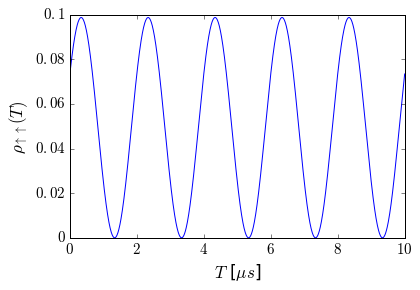

In [45]:
O= 2*pi*0+1*1
D = 2*pi *0.5
OE = sqrt(D**2+O**2)
T = linspace(0,10,1500)
t = 1/4*0+pi/2 *1


pee = 4*(O**2/OE**2)*sin(OE*t/2)**2 *(cos(D*T/2)*cos(OE*t/2) - D/OE *sin(D*T/2)*sin(OE*t/2))**2
plot(T,pee)
ylabel(r'$\rho_{\uparrow \uparrow}(T)$ ', fontsize=17)
xlabel("$T$ [$\mu s$]", fontsize=17)
plt.xticks([0,2, 4, 6, 8, 10],
        [ r'$0$','$2$', r'$4$', r'$6$', r'$8$', r'$10$'], fontsize=15)
plt.yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1],
           ['$0$', r'$0.02$', r'$0.04$', r'$0.06$', r'$0.08$', r'$0.1$'], fontsize=15)
savefig('Ramsey3.svg')

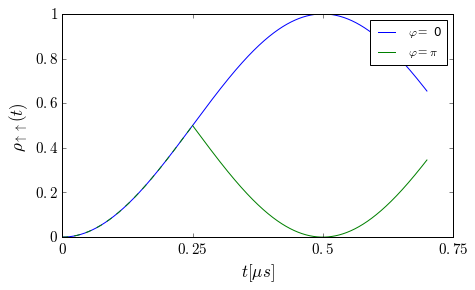

In [43]:
#Change the rabi frequency, detuning and decay rates.
plt.figure(figsize=(7,4))
psi0 = basis(3,0) #nS-State
tlist = linspace(0, 0.7, 2000)

omegaP = 2*pi; dP = omegaP*0; 
gamma_SX = 1/35.3*0; 
gamma_PX = 1/53.5*0; 

results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
#title('Rabi osc')
ylabel(r'$\rho_{\uparrow \uparrow}(t)$ ', fontsize=17)
xlabel("$t[\mu s]$", fontsize=17)
p2 = plot(results.times, results.expect[1],'b',label=r'$\varphi =$ 0',alpha = 1)
legend(loc='upper right')


dP = 0;
#tlist = linspace(0.25, 1, 2000)
results = la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX)
p3 = plot(results.times[714:2000], 1-results.expect[1][714:2000],'g-',label=r'$\varphi = \pi$',alpha = 1)
p4 = plot(results.times[0:714], results.expect[1][0:714],'g--',alpha = 1)
legend(loc='upper right')
#show()
#savefig('1_p_upup.pdf')


plt.xticks([0, 0.25, 0.5, 0.75],
           ['$0$', r'$0.25$', r'$0.5$', r'$0.75$'], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)

#, 2*pi, 3*pi, 4*pi, 5*pi, 6*pi
#, r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$'

savefig('phasejump.svg')

In [100]:
len(results.expect[1])

2000

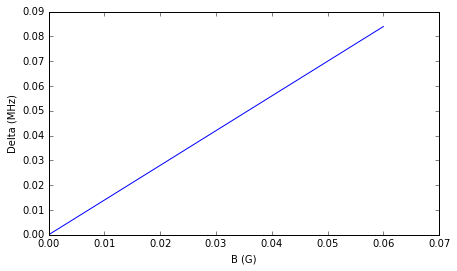

In [50]:
def lande_J(J,L,S = 1/2):
    J = L + S
    gj = 3/2 + (S*(S+1)-(L*(L+1)))/(2*J*(J+1))
    return gj

planckbar = 6.62607004e-34 # / (2 * np.pi)
bohr_magneton = 9.27400968e-24






mj2 = 3/2
J_up = 3/2
L_up = 1
gj2 = lande_J(J = J_up, L = L_up)
#print(gj_up)

mj1 = 1/2
J_down = 1/2
L_down = 0
gj1 = lande_J(J = J_down, L = L_down)
#print(gj_down)

Bf = np.linspace(0,0.06/10000,500)
Bfe = Bf * 10000


det = Bf * (bohr_magneton*(gj2*mj2-gj1*mj1))/planckbar
det = det * 1e-6



plt.figure(figsize=(7,4))
#plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('B (G)')
plt.ylabel('Delta (MHz)')
plt.plot(Bfe,det)

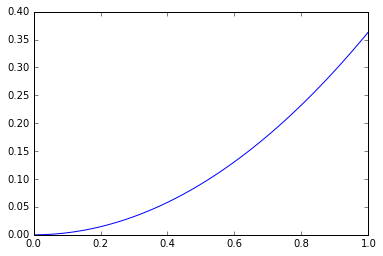

In [15]:
#Stark

alp = -7.27e-1 #MHz
ef = linspace(0 , 1 , 100)
v = -1/2 * alp *ef**2

plot(ef,v)

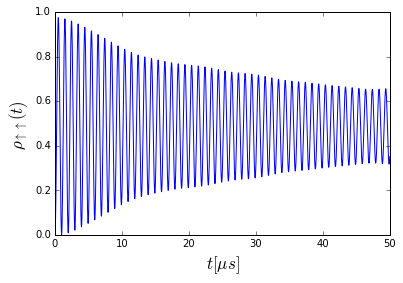

In [114]:
#f, ((ax1, ax2)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 8))
#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6, 7))
psi0 = basis(3,0)

T= 50
Nu= 4200
tlist = linspace(0, T, Nu)
##################################################
dP = 0; 
om = 1
omegaP = 2*pi
gamma_SX = 1/35.3*0; 
gamma_PX = 1/53.5*0;
sig_det = 1
Nruns = 250

time, exp0, exp1, exp2, exp3 = la3level_RWA_EfieldFluctuations(tlist,psi0,omegaP,dP,gamma_PX,gamma_SX,sig_det,Nruns)

#title('Rabi P')
ylabel(r'$\rho_{\uparrow \uparrow}(t)$ ', fontsize=17)
xlabel("$t[\mu s]$", fontsize=17)
p2 = plot(time,exp1)
#figure(2)
#omegaP = 2*pi
#sig_det= 2.5
#time, exp0, exp1, exp2, exp3 = la3level_RWA_EfieldFluctuations(tlist,psi0,omegaP,dP,gamma_PX,gamma_SX,sig_det,Nruns)
#p1 = plot(time,exp1,'r')

#plt.xticks([0, 10, 20, 30, 40,50],
#           ['$0$', r'$10$', r'$20$', r'$30$', r'$40$', r'$50$'], fontsize=15)
#plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
#           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)
savefig('Rabi_det_123.pdf')
#show()

#plt.xticks([0, 10, 20, 30, 40,50,60,70,80,90,100],
#           ['$0$', r'$10$', r'$20$', r'$30$', r'$40$', r'$50$', r'$60$', r'$70$', r'$80$', r'$90$', r'$100$'], fontsize=15)
#plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],
#           ['$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'], fontsize=15)